In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mod-10-ebac-ds/credito.csv


In [2]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def change_col_sys_us(df:pd.DataFrame, col:str) -> pd.DataFrame:
  df_aux = df
  try:
    df_aux[col] = df_aux[col].apply(lambda valor: float(valor.replace(".", "").replace(",", ".")))
    return df_aux
  except:
    print(f'This columns name: {col} wasnt found')
    exit()

def change_cols_sys_us(df:pd.DataFrame, cols:list =[]) -> pd.DataFrame:
  df_aux = df
  for c in cols:
    df_aux = change_col_sys_us(df_aux, c)
  return df_aux

def clean_df(df:pd.DataFrame, id:str ='id', ax=0, remove_empty_str:bool =False, cols_br_sys:list =[]) -> pd.DataFrame:
  df_aux = df

  try:
    df_aux = df_aux.drop(id, axis=1, inplace=False)
  except:
    pass
  
  if remove_empty_str:
    df_aux = df_aux.replace('', np.nan, inplace=False)

  if cols_br_sys != []:
    df_aux = change_cols_sys_us(df_aux, cols_br_sys)
  
  df_aux.dropna(axis=ax, inplace=True)
  return df_aux

def transf_col_str_to_bool(df:pd.DataFrame, col:str) -> pd.DataFrame:
  aux_c=[]
  aux_str=''
  df_aux = df
  try:
    for i in df_aux[col]:
      aux_c.append(i) if i not in df_aux else df_aux
    for c in aux_c:
      aux_str = col+'_'+c
      df_aux[aux_str] = df_aux[col].apply(lambda valor: 1 if valor==c else 0 )
    return df_aux
  except:
    print(f'This columns name: {col} wasnt found')
    exit()
    
def transf_cols_str_to_bool(df:pd.DataFrame, transf_cols=[]) -> pd.DataFrame:
    df_aux = df
    for c in transf_cols:
      df_aux = transf_col_str_to_bool(df_aux,c)
    return df_aux

def get_corrwith(df:pd.DataFrame, dependent_var=None, transf_cols=[], remove_id:str=None) -> pd.DataFrame:
  if remove_id:
    df_aux = df.drop(remove_id, axis=1)
  else:
    df_aux = df

  if len(transf_cols)>0:
    transf_cols_str_to_bool(df_aux, transf_cols)

  if dependent_var:
    try:
      df_aux = df_aux.corrwith(df_aux[dependent_var])
    except:
      print(f'This columns name: {dependent_var} wasnt found')
      df_aux = df_aux.corr()
      pass
  else:
    df_aux = df_aux.corr()

  return df_aux

def get_relationship(df:pd.DataFrame, col:str, value) -> float:
    try:
        return round(df[df[col] == value].shape[0]/df.shape[0], 4)
    except:
        print(f'This columns name: {col} wasnt found, OR teh value {value} selected there arent')
        exit()
        
        
def _calc_abs_freq(df:pd.DataFrame, col_absolute:str, col_reference = None, val_reference=-1) -> pd.DataFrame:
    try:
       col_absolute in df.columns
    except:
        print(f'Please, check column names:{col_absolute}, {col_refence} one or both can to be mistake, there are a problem')
        exit()
    try:
        col_reference in df.columns or col_reference==None
    except:
        print(f'Please, check column names:{col_absolute}, {col_reference} one or both can to be mistake, there are a problem')
        exit()
    if 'frequencia_absoluta' not in df.columns:
        aux_df = df[df[col_reference]==val_reference][col_absolute].value_counts().to_frame()
        aux_df.rename(columns={col_absolute: 'frequencia_absoluta'}, inplace=True)
        aux_df[col_absolute] = aux_df.index
    if val_reference >= 0:
        aux_df[col_reference] = val_reference
    aux_df.sort_values(by=[col_absolute])

    return aux_df

def set_df_freq_abs(df:pd.DataFrame, col_absolute:str, col_reference:str = None) -> pd.DataFrame:
    if col_reference:
        aux_c=[]
        aux_v=[]
        for i in df[col_reference]:
            if i not in aux_c:
              aux_c.append(i)
        for value in aux_c:
            aux_v.append(_calc_abs_freq(df,col_absolute,col_reference, value))
        aux = pd.concat(aux_v)
    else:
        aux = _calc_abs_freq(df=df, col_absolute=col_absolute)
    return aux

def set_df_freq_rel(df:pd.DataFrame, col_calc:str, col_reference:str = None, make_new_df=False) -> pd.DataFrame:
    try:
        col_calc in df.columns
    except:
        print(f'The value: {col_calc} cant found the coluna {df.columns}')
        exit()
        
    if make_new_df:
        aux_df = set_df_freq_abs(df, col_calc, col_reference)
    else:
        aux_df = df
    i=0
    if 'frequencia_rel' not in aux_df.columns:
        aux_df.insert(loc=0, column='frequencia_rel', value=float(0.0), allow_duplicates=False)
    
    for value in aux_df[col_calc]:
        sum_aux = aux_df[aux_df[col_calc]==value]['frequencia_absoluta'].sum()
        div_aux = aux_df['frequencia_absoluta'][i]/sum_aux
        #print(f'{sum_aux},{div_aux}')
        aux_df['frequencia_rel'][i] = div_aux
        i+=1
        
    return aux_df



In [3]:
df = pd.read_csv('../input/mod-10-ebac-ds/credito.csv', na_values=['na'])

In [4]:
df.head()

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,NaN,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28


In [5]:
df.columns

Index(['id', 'default', 'idade', 'sexo', 'dependentes', 'escolaridade',
       'estado_civil', 'salario_anual', 'tipo_cartao',
       'meses_de_relacionamento', 'qtd_produtos', 'iteracoes_12m',
       'meses_inativo_12m', 'limite_credito', 'valor_transacoes_12m',
       'qtd_transacoes_12m'],
      dtype='object')

In [6]:
print(df.dtypes)
df.select_dtypes('object').describe().transpose()


id                          int64
default                     int64
idade                       int64
sexo                       object
dependentes                 int64
escolaridade               object
estado_civil               object
salario_anual              object
tipo_cartao                object
meses_de_relacionamento     int64
qtd_produtos                int64
iteracoes_12m               int64
meses_inativo_12m           int64
limite_credito             object
valor_transacoes_12m       object
qtd_transacoes_12m          int64
dtype: object


,count,unique,top,freq
sexo,10127,2,F,5358
escolaridade,8608,5,mestrado,3128
estado_civil,9378,3,casado,4687
salario_anual,9015,5,menos que $40K,3561
tipo_cartao,10127,4,blue,9436
limite_credito,10127,9272,"1.438,21",11
valor_transacoes_12m,10127,10035,"3.851,51",3


In [7]:
df2 = clean_df(df, cols_br_sys=['limite_credito', 'valor_transacoes_12m'])
df2.head()

,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,12691.51,1144.90,42
1,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,8256.96,1291.45,33
2,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,3418.56,1887.72,20
4,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,4716.22,816.08,28
5,0,44,M,2,mestrado,casado,$40K - $60K,blue,36,3,2,1,4010.69,1088.07,24


In [8]:
print(df2.dtypes)
df2.select_dtypes('object').describe().transpose()

default                      int64
idade                        int64
sexo                        object
dependentes                  int64
escolaridade                object
estado_civil                object
salario_anual               object
tipo_cartao                 object
meses_de_relacionamento      int64
qtd_produtos                 int64
iteracoes_12m                int64
meses_inativo_12m            int64
limite_credito             float64
valor_transacoes_12m       float64
qtd_transacoes_12m           int64
dtype: object


,count,unique,top,freq
sexo,7081,2,M,3706
escolaridade,7081,5,mestrado,2591
estado_civil,7081,3,casado,3564
salario_anual,7081,5,menos que $40K,2792
tipo_cartao,7081,4,blue,6598


In [9]:
print(f'No DataFrame Original, a proporcao de adiplentes eh de: {100 * get_relationship(df,"default",0)}%')
print(f'No DataFrame Original, a proporcao de inadiplentes eh de: {100 * get_relationship(df,"default",1)}%')
print()
print(f'Enquanto que no DataFrame apos limeza dos dados NA, a proporcao de adiplentes eh de: {100 * get_relationship(df2,"default",0)}%')
print(f'Enquanto que no DataFrame apos limeza dos dados NA, a proporcao de inadiplentes eh de: {100 * get_relationship(df2,"default",1)}%')

No DataFrame Original, a proporcao de adiplentes eh de: 83.93%
No DataFrame Original, a proporcao de inadiplentes eh de: 16.07%

Enquanto que no DataFrame apos limeza dos dados NA, a proporcao de adiplentes eh de: 84.28%
Enquanto que no DataFrame apos limeza dos dados NA, a proporcao de inadiplentes eh de: 15.72%


In [10]:
df2 = transf_col_str_to_bool(df2,'salario_anual')

In [11]:
df2.head()

,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,salario_anual_$60K - $80K,salario_anual_menos que $40K,salario_anual_$80K - $120K,salario_anual_$40K - $60K,salario_anual_$120K +
0,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,12691.51,1144.90,42,1,0,0,0,0
1,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,8256.96,1291.45,33,0,1,0,0,0
2,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,3418.56,1887.72,20,0,0,1,0,0
4,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,4716.22,816.08,28,1,0,0,0,0
5,0,44,M,2,mestrado,casado,$40K - $60K,blue,36,3,2,1,4010.69,1088.07,24,0,0,0,1,0


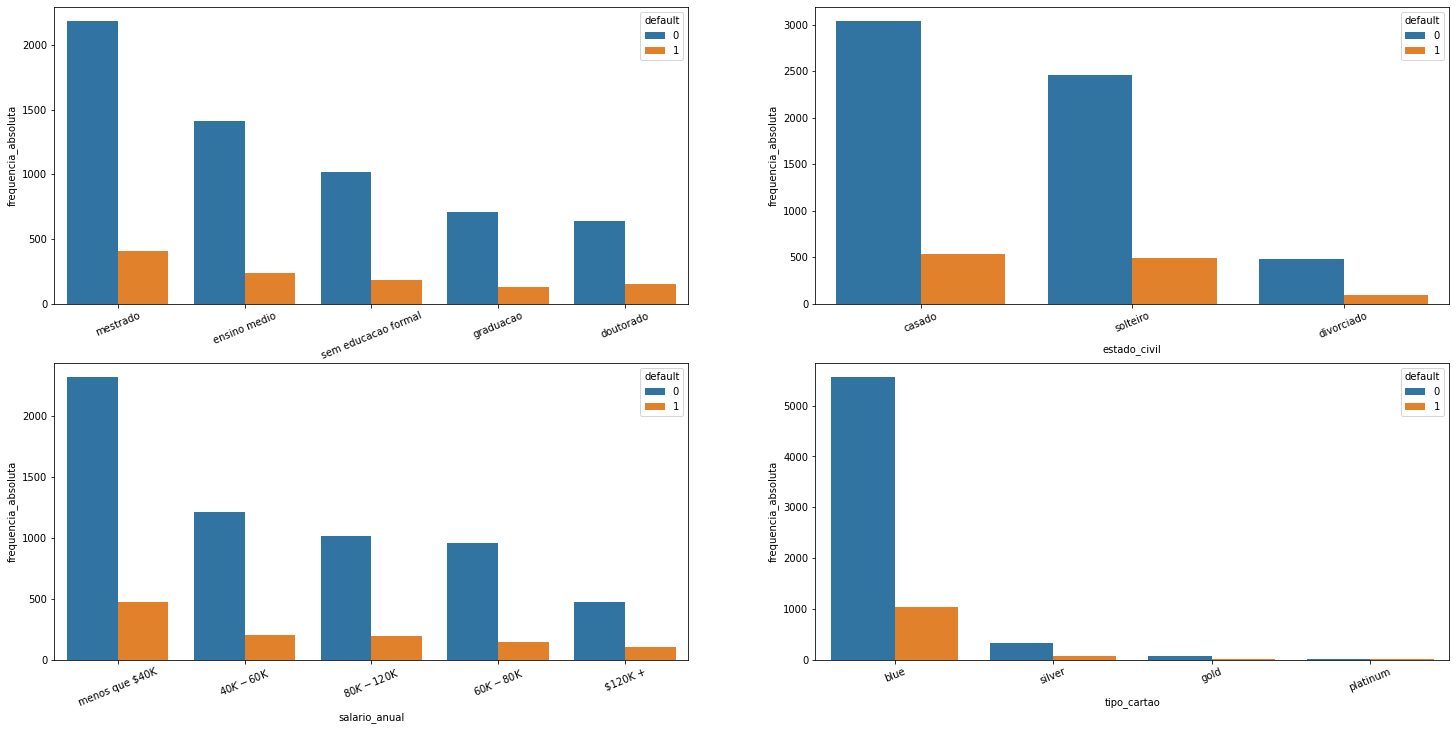

In [12]:
list_cols = ['escolaridade', 'estado_civil', 'salario_anual', 'tipo_cartao']
col_r = 'default'
c_plot=[]
x=0
y=0


for i in list_cols:
    c_plot.append(set_df_freq_abs(df2, col_absolute=i, col_reference='default'))
#print(c_plot)

figura, ex = plt.subplots(2,2, figsize=(25, 12))
for i in range(4):
    x=int(i/2)
    y=i%2
    f = sns.barplot(x=list_cols[i], y='frequencia_absoluta', hue=col_r, data=c_plot[i], ax=ex[x,y])
    plt.setp(f.get_xticklabels(), rotation=22.5)
figura.show()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


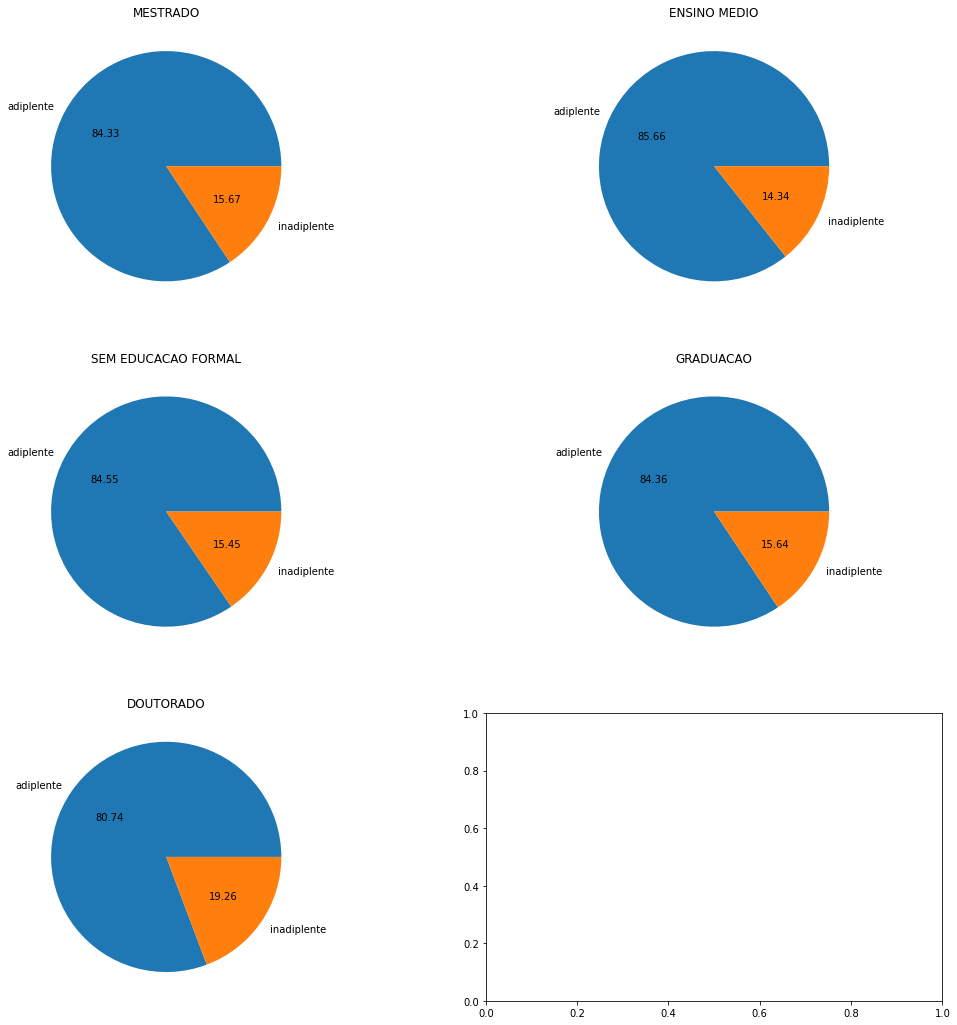

In [13]:
list_cols = ['escolaridade', 'estado_civil', 'salario_anual', 'tipo_cartao']
col_r = 'default'
c_plot2=[]
x=0
y=0
cont=0

for i in list_cols:   
    c_plot2.append(set_df_freq_rel(df=c_plot[cont], col_calc=i))
    cont+=1

l = int(c_plot2[0].shape[0]/2) if c_plot2[0].shape[0]%2==0 else int(c_plot2[0].shape[0]/2 + 1)
list_c = c_plot2[0]['escolaridade']

figura, ex = plt.subplots(int(l/2+l%2),int(l/2), figsize=(18, 18))
for i in range(l):
    x=int(i/2)
    y=i%2
    ex = plt.subplot2grid((int(l/2+l%2),int(l/2)),(x,y))
    plt.pie(x=c_plot2[0][c_plot2[0]['escolaridade']==list_c[i]]['frequencia_rel'], labels=['adiplente', 'inadiplente'], autopct='%.2f')
    plt.title(str.upper(list_c[i])) 
plt.show()


3


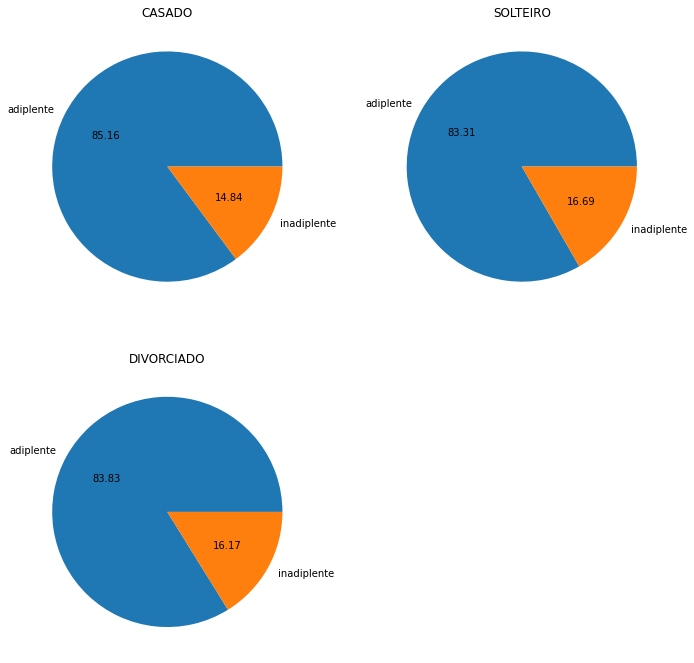

In [14]:
l = int(c_plot2[1].shape[0]/2) if c_plot2[0].shape[0]%2==0 else int(c_plot2[1].shape[0]/2 + 1)
print(l)
list_c = c_plot2[1]['estado_civil']

figura, ex = plt.subplots(int(l/2+l%2),int(l/2), figsize=(18, 18))
for i in range(l):
    x=int(i/2)
    y=i%2
    ex = plt.subplot2grid((3,3),(x,y))
    plt.pie(x=c_plot2[1][c_plot2[1]['estado_civil']==list_c[i]]['frequencia_rel'], labels=['adiplente', 'inadiplente'], autopct='%.2f')
    plt.title(str.upper(list_c[i])) 
plt.show()

In [15]:
aux = get_corrwith(df2,dependent_var='default',transf_cols=['escolaridade','estado_civil'])

aux = aux.to_frame()
aux

,0
default,1.000000
idade,0.008735
dependentes,0.011423
meses_de_relacionamento,0.009249
qtd_produtos,-0.145713
iteracoes_12m,0.193923
meses_inativo_12m,0.152732
limite_credito,-0.015816
valor_transacoes_12m,-0.160379
qtd_transacoes_12m,-0.357261


In [16]:
type(aux)

pandas.core.frame.DataFrame

In [17]:
aux['id'] = aux.index
aux.rename(columns={0: 'correlacao'}, inplace=True)
aux

        #aux_df = df[df[col_reference]==val_reference][col_absolute].value_counts().to_frame()
        #aux_df.rename(columns={col_absolute: 'frequencia_absoluta'}, inplace=True)
        #aux_df[col_absolute] = aux_df.index

,correlacao,id
default,1.000000,default
idade,0.008735,idade
dependentes,0.011423,dependentes
meses_de_relacionamento,0.009249,meses_de_relacionamento
qtd_produtos,-0.145713,qtd_produtos
iteracoes_12m,0.193923,iteracoes_12m
meses_inativo_12m,0.152732,meses_inativo_12m
limite_credito,-0.015816,limite_credito
valor_transacoes_12m,-0.160379,valor_transacoes_12m
qtd_transacoes_12m,-0.357261,qtd_transacoes_12m


In [18]:
list_plot=[]
for i in range(aux.shape[0]):
    if aux['id'][i] != 'default':
        if aux['correlacao'][i] > 0.15 or aux['correlacao'][i] < -0.15:
            list_plot.append([aux['id'][i], aux['correlacao'][i]])
            
list_plot


[['iteracoes_12m', 0.19392250185474755],
 ['meses_inativo_12m', 0.15273201489101293],
 ['valor_transacoes_12m', -0.1603788926992216],
 ['qtd_transacoes_12m', -0.3572610755987701]]

In [19]:
print(list_plot[1][0])
df2[list_plot[1][0]] == df2.meses_inativo_12m

meses_inativo_12m


0        True
1        True
2        True
4        True
5        True
         ... 
10120    True
10121    True
10122    True
10124    True
10126    True
Name: meses_inativo_12m, Length: 7081, dtype: bool

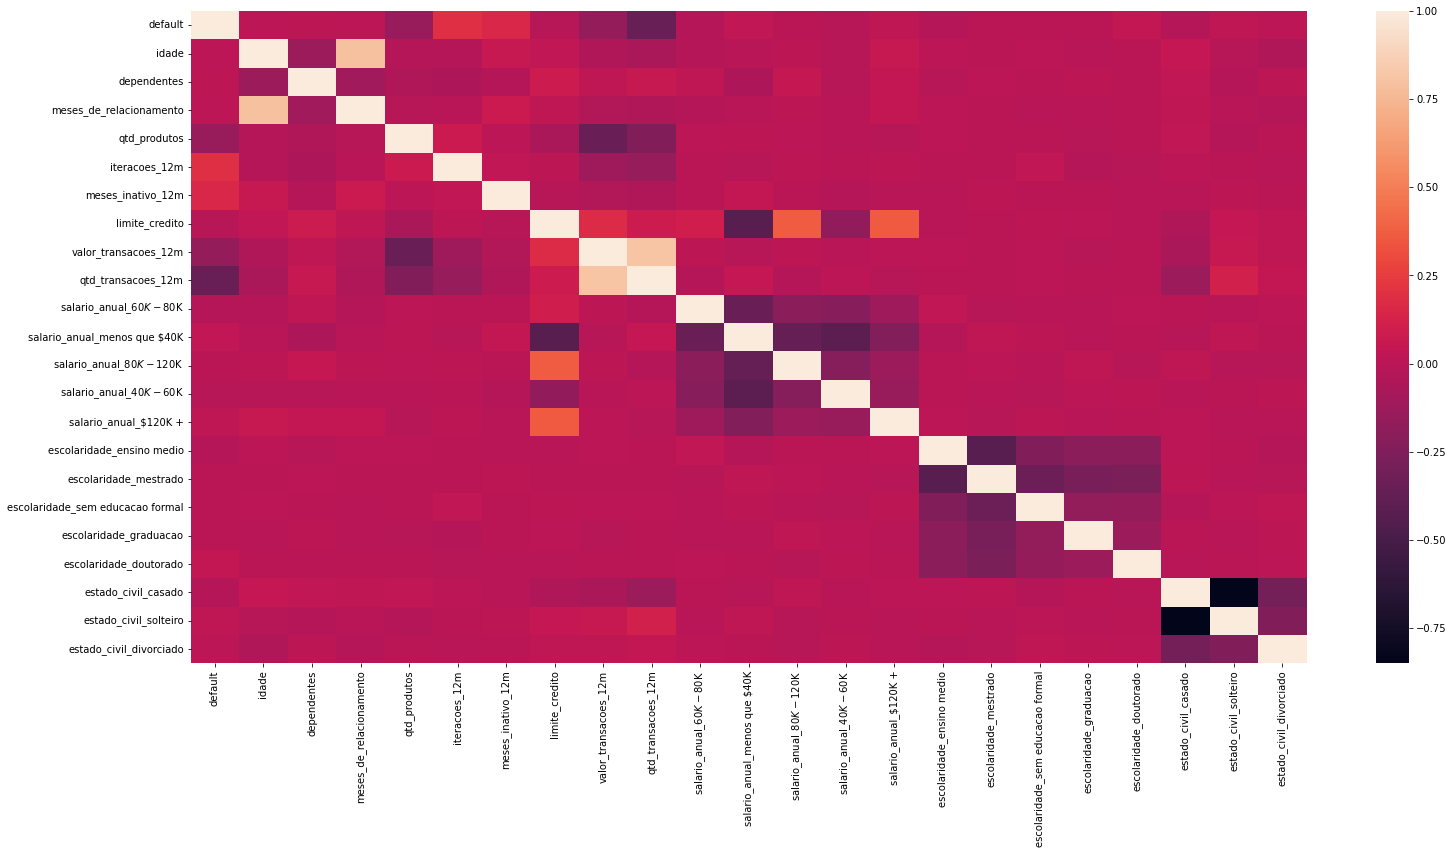

In [20]:
figura, ex = plt.subplots(1,1, figsize=(25, 12))
sns.heatmap(get_corrwith(df2));

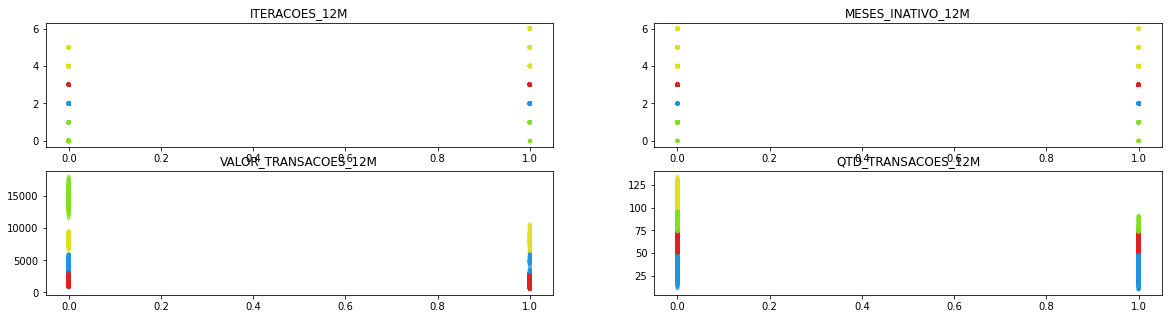

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

cluster = np.array([])
cont = 0
colors = ['#DF2020', '#81DF20', '#2095DF', '#DFDF20']

figura, ex = plt.subplots(2,2, figsize=(20, 5), sharex=True)

for col in list_plot:    
    kmeans = KMeans(n_clusters=4, random_state=0)
    cluster = np.array(kmeans.fit_predict(df2[['default',col[0]]]))
    cluster = pd.Series(cluster)

    centroids = kmeans.cluster_centers_
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]

    x = cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
    y = cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})
    c = cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})
    
    c_x=int(cont/2)
    c_y=cont%2
    ex = plt.subplot2grid((2,2),(c_x,c_y))
    plt.scatter(df2.default, df2[col[0]], alpha = 0.6, s=10, c=c)
    plt.title(str.upper(col[0])) 
    
    cont += 1


    
    
#df2['cluster'] = kmeans.fit_predict(df2[['default','qtd_transacoes_12m']])

#centroids = kmeans.cluster_centers_
#cen_x = [i[0] for i in centroids] 
#cen_y = [i[1] for i in centroids]
#df2['cen_x'] = df2.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
#df2['cen_y'] = df2.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})

#colors = ['#DF2020', '#81DF20', '#2095DF', '#DFDF20']

#df2['c'] = df2.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})
#f = plt.scatter(df2.default, df2.qtd_transacoes_12m, alpha = 0.6, s=10, c=df2.c,)

#df2['cluster'] = kmeans.fit_predict(df2[['default','qtd_transacoes_12m']])



figura.show()


**TRABALHO PARA ENCERRAMENTO DO MODULO DE PYTHON DO CURSO CIENCIA DE DADOS DA EBAC** 

**1. Introducao**
    
    A funcao desse estudo e tentar descobrir alguma relacao que nos leve a entender o que faz um cliente se tornar inadiplente, ou ao menos um indicador de que isso possa vir a ocorrer, para tanto usamos um banco de dados disponivel no link 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/develop/dataset/credito.csv', os dados vieram sem tratamento previo, necessitando por tanto de limpeza de valores nulos, como tambem transformacao de valores inicialmente em forma de *object* para *float*. 
    
    
**2. Contrucao do Programa:**
    
    Foi criado um grupo de funcoes para trabalhar com os dados a saber:
    
    1o) change_col_sys_us(df:pd.DataFrame, col:str):
        DEFINICAO: essa funcao transforma o padrao de numeracao existente no Brasil, onde usa-se "." para marcar milhar, e "," para marcar casa decimal em padrao Norte Americano, intendivel pelo Python, transformando um "str" em "float".
        RECEBE: "df" uma variavel pd.DataFrame, e "col" uma variavel string que informa o nome da coluna a ser tratada.
        RETORNA: o mesmo pd.DataFrame recebido porem agora com a columa "col" modificada.
    
    2o) change_cols_sys_us(df:pd.DataFrame, cols:list =[]):
        DEFINICAO: essa funcao transforma o padrao de numeracao existente no Brasil, onde usa-se "." para marcar milhar, e "," para marcar casa decimal em padrao Norte Americano, intendivel pelo Python, transformando um "str" em "float".
        RECEBE: "df" uma variavel pd.DataFrame, e uma lista de nomes de colunas "cols" a ser tratada.
        RETORNA: o mesmo pd.DataFrame recebido porem agora com a columa "col" modificada.
    
    3o) clean_df(df:pd.DataFrame, id:str ='id', ax=0, remove_empty_str:bool =False, cols_br_sys:list =[]):
        DEFINICAO: essa funcao remove linhas ou colunas com valores nulos.
        RECEBE: "df" uma pd.DataFrame que sera tratada, "id" a coluna portdora da chave primaria, a qual nao tem utilidade em analise de dados uma vez que jamais se repete, quando nao passada assume o valor de id por padrao,  ax referece a o que sera apagao, quando 0 se refere a linha quando 1 referece a linha da tabela df, por padrao a linha eh renovida, remove_empty_str recebe True ou False, indica se :colunas com valores string as quais essas estao vazias serao apagadas, por padrao eh False, cols_br_sys lista de nome de colunas que serao tratadas, por padrao eh um lista vazia
        RETORNA: o mesmo pd.DataFrame recebido porem agora com a columa "col" modificada.
    
    4o) transf_col_str_to_bool(df:pd.DataFrame, col:str):
        DEFINICAO: trabalha fazendo um Enconder, ou seja transfomando um coluna com variavel categorica em particular em varias colunas com variavel 0 ou 1.
        RECEBE: "df" uma variavel pd.DataFrame, e uma coluna "col" a ser tratada.
        RETORNA: o mesmo pd.DataFrame recebido porem agora com a columa "col" modificada.
    
    5o) transf_cols_str_to_bool(df:pd.DataFrame, transf_cols=[]):
        DEFINICAO: trabalha fazendo um Enconder, ou seja transfomando um lista de colunas com variavel categoricas em colunas com variavel 0 ou 1.
        RECEBE: "df" uma variavel pd.DataFrame, e uma lista de colunas "transf_cols" a ser tratada, que eh normalmente uma lista vazia.
        RETORNA: o mesmo pd.DataFrame recebido porem agora com a columa "col" modificada.
        
    6o) get_corrwith(df:pd.DataFrame, dependent_var=None, transf_cols=[], remove_id:str=None):
        DEFINICAO: calcula a correlacao entre uma coluna (variavel dependente) com outras colunas numericas (variaveis independentes).
        RECEBE: "df" uma variavel pd.DataFrame, uma coluna que contem a variavel q se deseja estudar "dependent_var" essa pode estar None, entao sera calculado a correlacao total da pd.DataFrame recebida, e uma lista de colunas "transf_cols" a qual serao usadas para calcular correlacao.
        RETORNA: um novo pd.DataFrame onde o index 'e o nome de cada variavel e mais uma coluna com as correlacoes.        
    
    7o) get_relationship(df:pd.DataFrame, col:str, value):
        DEFINICAO: calcula proporcao existente de um valor dentro de uma coluna.
        RECEBE: "df" uma variavel pd.DataFrame, uma nome de uma coluna que se deseja estudar "col", um certo valor "value" contido nessa "col" a qual se quer saber a proporcao.
        RETORNA: um numero flot.
    
    8o) set_df_freq_abs(df:pd.DataFrame, col_absolute:str, col_reference:str = None):
        DEFINICAO: calcula frequencia absoluta de uma dada coluna podendo estar relacionada ou nao a um valor de outra coluna.
        RECEBE: "df" uma variavel pd.DataFrame, uma coluna a qual sera calculado o valor absoluto de cada uma de seus valores "col_absolute", uma coluna de referencia a qual caso exista serve para dividir em todos os seus valores a frequencia absoluda da "col_absolute" chamada de "col_reference" com valor padrao em None..
        RETORNA: um novo pd.DataFrame com os valores absoluto de cada valor assumido para uma dada coluna (variavel).
    
    9o) set_df_freq_rel(df:pd.DataFrame, col_calc:str, col_reference:str = None, make_new_df=False)
        DEFINICAO: calcula frequencia relativa de uma dada coluna podendo estar relacionada ou nao a um valor de outra coluna.
        RECEBE: "df" uma variavel pd.DataFrame, uma coluna a qual sera calculado o valor relativo de cada uma de seus valores "col_calc", uma coluna de referencia a qual caso exista serve para dividir em todos os seus valores a frequencia relativa da "col_calc" chamada de "col_reference" com valor padrao em None.
        RETORNA: um novo pd.DataFrame com os valores relativos, de cada valor assumido para uma dada coluna (variavel).
        
        
**3. Exploração de Dados:**

    Nos blocos de CODIGO [1] e [2] foi importado as bibliotecas python e criado as funcoes com as quais trabalhamos para realizar esse estudo
        
    Ja nos blocos de codigo que vao do [3] ao [8] foi importado o Banco de Dados, realizado os tratamentos preliminares do mesmo, removendo valores duplicados, nulos, tornando-se quando necessario variaveis string em variveis float
    
    No bloco [9] realizamos nosso primenira analise, verificando as proporcoes em % dos adiplentes ('default' = 0) e dos inadiplentes ('default' = 1), e percebemos que mesmo depois da limpeza realizada nos blocos anteriores a proporcao se manteve, provando que nao ha perda de informacoes relevantes no descarte de valores nulos.
    
    Apos isso nos blocos [10] e [11] alteramos o DataFrame para conter um conjunto de colunas novas que fazem o Enconder da coluna "salario_anual" de modo que possamos aplicar calculos matematicos a essa como por exemplo o calculo de correlacao, com a variavel dependente.
    
    Os blocos que vao do [12] o [14] realizamos analise graficas sobre as variaveis categoricas existentes, nao percebendo nada muito relevante.
    A informacao mas destoante nessa analise foi que clientes com Doutorado parecem ter um grao inadiplencia maior que os outros graus de escolaridade em 4%. Alem disso os Casados parecem pagar melhor suas contas que os solteiros e divorciados, talvez por terem mulheres pegando no pe (isso deve constar em uma analise futura)
    
    Seguindo na analise durante os blocos [15] ate o [20] calclamos transformamos as variaveis categoricas faltantes em 0 ou 1, fizemos a correlacao linear, realizamos o grafico de "Calor" entre todas as variaveis, e elencamos as variaveis mais relevantes linearmente para continuar trabalhando com elas, sendo essas gravadas em uma lista chamada de de list_plot: [['iteracoes_12m', 0.19392250185474755], ['meses_inativo_12m', 0.15273201489101293], ['valor_transacoes_12m', -0.1603788926992216], ['qtd_transacoes_12m', -0.3572610755987701]].
    
    Por fim em [21] realizamos um cluster com as variaveis salvas no list_plot, e imprimimos os graficos com 4 separacoes para realizarmos analise grafica.
    
    
**4. Conclucao**
    
    As variavis que demostraram esplicar melhor o endividamento das pessoas foram: A) "valor_transacoes_12m" tendo um grau de endividamento quase nulo naqueles individuos que mantem um valor de transacao acima dos 10.000,00 ano, B) "qtd_transacoes_12m", tambem nos informando que o grau de individamento eh muito baixo em quem transaciona mais com o banco, por ultimo c)"iteracoes_12m" que nos informa que fica mais inadiplente quem tem mais iteracao.
    Porem nao consideramos nenhuma dessas variaveis um bom paramentro para explicar o endividamento, esse estudos para as variaveis nos passadas foi considerado inconclusivo, nao sendo adequado para criar uma inteligencia artificial que nos dira com bom grau de certeza o cliente que desejamos no banco.
    Sugerimos por fim criar um relacionamento mas estreito com os clientes, para tentar melhorar o Banco de Dados, talvez tentando obter dados de padrao de conpra, e tambem dados familiares como numero de membros, para criamos coluna salario_anual/per capito.

















